In [ ]:
# ! pip install transformers
! pip install datasets sentencepiece rouge_score -q

In [ ]:
#Optional
pip install transformers[torch] -q 

In [3]:
import os
os.environ["WANDB_MODE"] = "dryrun"

In [5]:
import torch
import numpy as np
import datasets
from datasets import load_dataset, load_metric
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline
)

from tabulate import tabulate
import nltk
from datetime import datetime

# Importing model

In [6]:
model_name = "sshleifer/distilbart-xsum-12-3"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [7]:
encoder_max_length = 256  # demo
decoder_max_length = 64

# Preparing dataset

In [8]:
from datasets import load_dataset
#https://huggingface.co/datasets/gopalkalpande/bbc-news-summary

dataset = load_dataset("gopalkalpande/bbc-news-summary")

Generating train split:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 2224
    })
})


In [10]:
for k,v in dataset["train"][0].items():
  print(k)
  print(v)

File_path
politics
Articles
Budget to set scene for election..Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour...Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about £2bn to spare...- Increase in the stamp duty threshold from £60,000. - A freeze on petrol duty. - An extension of tax credit scheme for poorer families. - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much 

In [11]:
def flatten(example):
    return {
        "Articles": example["Articles"],
        "Summaries": example["Summaries"],
    }

dataset = dataset["train"].map(flatten, remove_columns=["File_path"])

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [12]:
print(dataset)

Dataset({
    features: ['Articles', 'Summaries'],
    num_rows: 2224
})


In [43]:
article_len = [len(x['Articles'].split()) for x in dataset]
highlights_len = [len(x['Summaries'].split()) for x in dataset]

array([[<Axes: title={'center': 'article Length'}>,
        <Axes: title={'center': 'highlights Length'}>]], dtype=object)

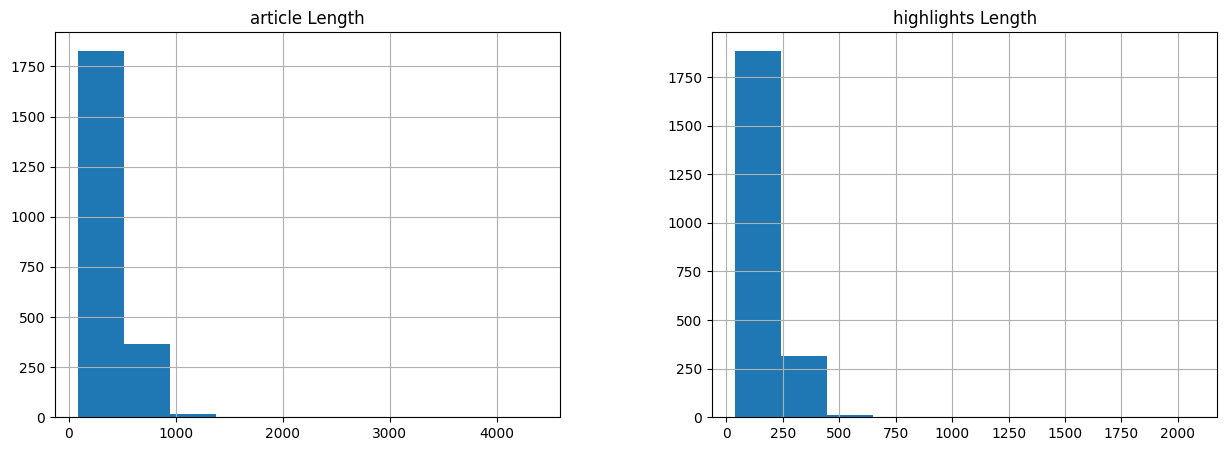

In [28]:
import pandas as pd

data = pd.DataFrame([article_len, highlights_len]).T
data.columns = ['article Length', 'highlights Length']

data.hist(figsize=(15,5))

In [29]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [30]:
show_random_elements(dataset)

,Articles,Summaries
0,"Wales silent on Grand Slam talk..Rhys Williams says Wales are still not thinking of winning the Grand Slam despite a third Six Nations win...""That's the last thing on our minds at the moment,"" said Williams, a second- half replacement in Saturday's 24-18 win over France in Paris. ""We all realise how difficult a task it is to go up to Scotland and beat them. ""We've come unstuck there a couple of times recently so our focus is on that game and we'll worry about Ireland hopefully after we've beaten Scotland."" With captain Gareth Thomas ruled out of the rest of the campaign with a broken thumb, Williams is vying for his first start in the championship so far...Kevin Morgan is probably favourite to replace Thomas at full-back, leaving Williams and Hal Luscombe to battle for the right wing berth. A hamstring injury denied Luscombe the opportunity to make a third successive start, but the Dragons winger is expected to be fit for the trip to Murrayfield on 13 March. Hooker Robin McBryde is doubtful after picking up a knee injury in Paris, but centre Sonny Parker and flanker Colin Charvis are set to recover from injury to be in contention for selection. Said Wales assistant coach Scott Johnson: ""They've worked through the weekend and the reports are a bit more positive. ""So we're getting a couple back and that adds to the depth of the squad."" Scotland secured their first win of the campaign on Saturday by grinding out an 18-10 win over Italy...Matt Williams' side has shown little in attack, but Johnson insisted the Scots will be difficult opposition to break down. ""Italy are really brave opposition and sometimes it's very hard to win,"" he said. ""So an ugly win can be just as effective as a 30 or 40 point victory. ""Scotland are a hard side and very underrated so we're not taking anything for granted. ""We're not basking in the glory of winning our first three games. We've got to be diligent in our preparation. ""That's my job and we've got to make sure we're focused.""","Scotland secured their first win of the campaign on Saturday by grinding out an 18-10 win over Italy.""That's the last thing on our minds at the moment,"" said Williams, a second- half replacement in Saturday's 24-18 win over France in Paris.""Italy are really brave opposition and sometimes it's very hard to win,"" he said.Rhys Williams says Wales are still not thinking of winning the Grand Slam despite a third Six Nations win.""We've come unstuck there a couple of times recently so our focus is on that game and we'll worry about Ireland hopefully after we've beaten Scotland.""""That's my job and we've got to make sure we're focused.""With captain Gareth Thomas ruled out of the rest of the campaign with a broken thumb, Williams is vying for his first start in the championship so far.Matt Williams' side has shown little in attack, but Johnson insisted the Scots will be difficult opposition to break down."
1,"Milburn defends poster campaign..Labour's election chief Alan Milburn has defended his party's campaign posters amid Tory claims the ads were nothing short of ""sly anti-Semitism""...Mr Milburn said he appreciated people's concerns, but insisted that ""what they were was anti-Tory"" and ""not in any way, shape or form anti-Semitic"". He was responding to Tory spokesman Julian Lewis who said the ads were part of a wider trend of smearing the party. Labour has withdrawn two controversial posters and launched four new designs...A row was sparked after the party published posters appearing to depict Michael Howard, who is Jewish, as Fagin, and as a flying pig, amid claims they were anti-Semitic. The posters were labelled a ""big misjudgement"" by the Conservatives who said Labour's ""first shot in the election has badly backfired""...The posters were among a series of ideas shown to Labour members, who were asked to vote on their favourite. Labour has taken them off its website, saying members preferred other posters. The party's four n

In [53]:
def list2samples(example):
    documents = []
    summaries = []
    documents += example["Articles"]
    summaries += example["Summaries"]
    return {"Articles": documents, "Summaries": summaries}


dataset = dataset.map(list2samples, batched=True)

train_data_txt, validation_data_txt = dataset.train_test_split(test_size=0.1).values()
# Split the validation dataset into validation and test sets
validation_data_txt, test_data_txt = validation_data_txt.train_test_split(test_size=0.5).values()

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [54]:
print("Training dataset size:", len(train_data_txt))
print("Validation dataset size:", len(validation_data_txt))
print("Test dataset size:", len(test_data_txt))

Training dataset size: 2001
Validation dataset size: 111
Test dataset size: 112


In [33]:
validation_data_txt[0]

{'Articles': "Ireland 17-12 South Africa..Ronan O'Gara scored all Ireland's points as the home side claimed only their second ever win over South Africa on an emotional day at Lansdowne Road...O'Gara's first-half try, poached after a quick tap-penalty, helped the Irish to a 8-3 lead at half-time. Three further O'Gara penalties extended Ireland's lead to 17-6 as the game entered the final quarter. Two Percy Montgomery penalties set up a frantic finish but Ireland held out to claim a famous victory. Ireland began strongly and were never led, but the match was tense and closely fought throughout. Aware of the threat posed by the South Africans, Ireland pressed hard from the outset, and played some impressive rugby while searching for a breakthrough. Early on, Denis Hickie thought he was in for a try after a delightful backline move but Shane Horgan's pass was adjudged to have gone forward by referee Paul Honiss...Ireland continued to press and they showed their intent by opting for a line

In [57]:
def batch_tokenize_preprocess(batch, tokenizer, max_source_length, max_target_length):
    source, target = batch["Articles"], batch["Summaries"]
    source_tokenized = tokenizer(
        source, padding="max_length", truncation=True, max_length=max_source_length
    )
    target_tokenized = tokenizer(
        target, padding="max_length", truncation=True, max_length=max_target_length
    )

    batch = {k: v for k, v in source_tokenized.items()}
    # Ignore padding in the loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in target_tokenized["input_ids"]
    ]
    return batch


train_data = train_data_txt.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=train_data_txt.column_names,
)

validation_data = validation_data_txt.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=validation_data_txt.column_names,
)
# test_data = test_data_txt.map(
#     lambda batch: batch_tokenize_preprocess(
#         batch, tokenizer, encoder_max_length, decoder_max_length
#     ),
#     batched=True,
#     remove_columns=test_data_txt.column_names,
# )

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

# Training

In [16]:
nltk.download("punkt", quiet=True)

metric = datasets.load_metric("rouge")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results from ROUGE
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

<ipython-input-16-215be6d63470>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [35]:
training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    num_train_epochs=3,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,  # demo
    per_device_eval_batch_size=4,
    # learning_rate=3e-05,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.1,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=50,
    save_total_limit=3,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.evaluate()

{'eval_loss': 4.759574890136719,
 'eval_rouge1': 26.0716,
 'eval_rouge2': 11.5044,
 'eval_rougeL': 20.1535,
 'eval_rougeLsum': 20.3727,
 'eval_gen_len': 24.3229,
 'eval_runtime': 43.7658,
 'eval_samples_per_second': 5.095,
 'eval_steps_per_second': 1.28}

In [36]:
trainer.train()

Step,Training Loss
50,2.424800
100,2.528000
150,2.329100
200,2.252800
250,2.376900
300,2.234800
350,2.322700
400,2.332800
450,2.307600
500,2.432600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a G

TrainOutput(global_step=1503, training_loss=2.2044133886209107, metrics={'train_runtime': 808.2918, 'train_samples_per_second': 7.427, 'train_steps_per_second': 1.859, 'total_flos': 1858402477670400.0, 'train_loss': 2.2044133886209107, 'epoch': 3.0})

In [ ]:
# import shutil
# import os

# # Define the folder you want to zip
# folder_to_zip = "/content/results/checkpoint-5000"

# # Define the name for the zip file
# zip_file_name = "bart.zip"

# # Define the path where you want to save the zip file
# zip_destination = "/content"

# # Create a full path for the zip file
# zip_file_path = os.path.join(zip_destination, zip_file_name)

# # Create the zip file
# shutil.make_archive(zip_file_path[:-4], 'zip', folder_to_zip)

# # Optional: If you want to delete the original folder after zipping
# shutil.rmtree(folder_to_zip)

# # Check if the zip file is created successfully
# if os.path.exists(zip_file_path):
#     print(f"Folder '{folder_to_zip}' zipped successfully as '{zip_file_path}'")
# else:
#     print("Failed to create zip file.")

In [66]:
trainer.save_model("Bart-bcc-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}


In [38]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Inference

In [58]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Articles"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_name)

test_samples = test_data_txt.select(range(16))

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [59]:
print(
    tabulate(
        zip(
            range(len(summaries_after_tuning)),
            summaries_after_tuning,
            summaries_before_tuning,
        ),
        headers=["Id", "Summary after", "Summary before"],
    )
)
print("\nTarget summaries:\n")
print(
    tabulate(list(enumerate(test_samples["Summaries"])), headers=["Id", "Target summary"])
)
print("\nSource documents:\n")
print(tabulate(list(enumerate(test_samples["Articles"])), headers=["Id", "Document"]))

  Id  Summary after                                                                                                                                                                                                                                                                                                                        Summary before
----  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------------------------------------------------------------------------------------------------------------------------------------
   0  But Pompey chased, harried and unsettled a Chelsea side as the south-coast side started to gain the upper hand and almost took the lead through Quashie.Chelsea had been cont

In [67]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model="Bart-bcc-model")
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
In a bustling metropolis, nestled amidst towering skyscrapers and neon signs, lived a
tiny robot named Bolt. Unlike his sleek, industrial brethren designed for heavy labor,
Bolt was crafted from recycled materials, his body a patchwork of mismatched gears
and wires. Despite his humble appearance, Bolt possessed an extraordinary ability:
he could understand and converse with animals.

One day, while scavenging for spare parts in a forgotten alleyway, Bolt stumbled
upon a group of frightened pigeons huddled together. A menacing alley cat,
notorious for its predatory prowess, had them cornered. Using his knowledge of
animal communication, Bolt negotiated a truce. The cat, impressed by Bolt's
ingenuity, agreed to leave the pigeons alone in exchange for a daily offering of
leftover scraps from Bolt's tinkering sessions. News of Bolt's feat spread throughout
the city's animal kingdom, and soon, creatures of all shapes and sizes sought his
counsel. From helping a lost squirrel reunite with its family to mediating a squabble
between territorial dogs, Bolt became the unlikely hero of the urban jungle.
"""
print(pipe(custom_dialogue, **gen_kwargs))

[{'summary_text': "The cat, impressed by Bolt's transformations, agreed to leave the pigeons alone in exchange for a daily offering of206leftover scraps from Bolt's tinkering sessions.Despite his humble appearance, Bolt possessed an extraordinary ability:akings that could understand and converse with animals, and soon, creatures of all shapes"}]


**Inference Summary:**

[{'summary_text': "The cat, impressed by Bolt's transformations, agreed to leave the pigeons alone in exchange for a daily offering of206leftover scraps from Bolt's tinkering sessions.Despite his humble appearance, Bolt possessed an extraordinary ability:akings that could understand and converse with animals, and soon, creatures of all shapes"}]


**Possible Summary:**

A resourceful robot named Bolt, built from recycled parts, uses his unique ability to understand animals to help them in the city. He negotiates with a cat to protect pigeons, and his actions make him a hero to the city's animal residents.

This story features elements of human-technology interaction, animal communication, and unexpected heroes, which might be less common in a summarization training dataset. By comparing the summary generated by your model to this possible summary, you can assess how well it grasps the story's key points and condenses the information.